In [ ]:
# Menambahkan path direktori Kode_Skripsi untuk mengimpor file functions.py
import sys
sys.path.append('/content/drive/MyDrive/Kode_Skripsi')

In [ ]:
!cp /content/drive/MyDrive/Kode_Skripsi/functions.py /content/

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb

import matplotlib.pyplot as plt
from xgboost.sklearn import XGBClassifier
from xgboost.callback import EarlyStopping
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import f1_score, precision_score, roc_auc_score,log_loss, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

import copy
import functions
import os
import joblib

In [ ]:
# Mengabaikan warning penggunaan processor dan konfigurasi penggunaan weight terbaik dari epoch sebelumnya
functions.ignore_warnings()

In [ ]:
# Mengambil dataset RT IoT 2022
rt_iot2022_6classes = '/content/drive/MyDrive/Dataset_Skripsi/6_Classes/RT_IOT2022_6Classes.csv'

df = pd.read_csv(rt_iot2022_6classes)

# Memisahkan kolom fitur dan target
X = df.drop(columns=['Attack_type'])
y = df['Attack_type']

In [ ]:
# Menyimpan label asli sebelum encoding agar tidak ikut termodifikasi
y_label = y.copy()

# Melakukan encoding label utama (y) sekali untuk StratifiedKFold
label_encoder_y = LabelEncoder()
y_encoded = label_encoder_y.fit_transform(y.squeeze())

In [ ]:
# Menampilkan hasil encoding
functions.show_label_encoding(y, y_encoded)

===== Mapping Label Encoding (Attack_type) =====
     Label_Original  Label_Encoded
     ARP_poisioning              0
     DDOS_Slowloris              1
  NMAP_OS_DETECTION              2
      NMAP_TCP_scan              3
      NMAP_UDP_SCAN              4
NMAP_XMAS_TREE_SCAN              5


#XGBoost

In [ ]:
# Melakukan Stratified K-Fold dengan 5 fold dan hasilnya diacak
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Memastikan folder Model_Skripsi tersedia
os.makedirs("/content/drive/MyDrive/Model_Skripsi/", exist_ok=True)

In [ ]:
# Melakukan inisialisasi untuk menyimpan kurva metrik per epoch dalam setiap fold
fold_logloss_curve = []
fold_accuracy_curve = []

# Melakukan inisialisasi untuk nantinya menyimpan metrik setiap fold
fold_results = {
    'fold': [],
    'accuracy': [],
    'f1_score': [],
    'precision': [],
    'roc_auc': [],
    'log_loss': []
}
evals_result = {}

# Melakukan inisialisasi model terbaik
best_model = None

best_logloss = float('inf')
best_preds = None
best_y_true = None
best_fold = -1

# Melakukan inisialisasi untuk nilai epoch dan patience yang sedang digunakan
n_epochs = 50
n_earlystop = 15

# Melakukan Cross-validation
for fold, (train_idx, test_idx) in enumerate(skf.split(X, y_encoded)):
    eval_result_this_fold = {}
    print(f"\nFold {fold+1}")

    # Melakukan split data
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Melakukan encoding dan scaling
    X_train_np, X_test_np, y_train_np, y_test_np = functions.encoding_rt_iot22_balanced(X_train, X_test, y_train, y_test)

    # Menggunakan compute class weights untuk bobot balancing dataset
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train_np),
        y=y_train_np
    )
    sample_weights = class_weights[y_train_np]

    # Membuat DMatrix
    dtrain = xgb.DMatrix(X_train_np, label=y_train_np, weight=sample_weights)
    dvalid = xgb.DMatrix(X_test_np, label=y_test_np)

    # Menentukan parameter XGBoost yang digunakan
    params = {
        "objective": "multi:softprob",
        "num_class": len(np.unique(y_train_np)),
        "eval_metric": ["mlogloss", "merror"],
        "eta": 0.1,
        "seed": 42,
        "verbosity": 1,
    }


    evals = [(dvalid, "eval"), (dtrain, "train")]

    # Melakukan training model
    xgb_model = xgb.train(
        params,
        dtrain,
        num_boost_round=n_epochs,
        evals=evals,
        evals_result=eval_result_this_fold,
        early_stopping_rounds=n_earlystop,
        verbose_eval=True
    )

    # Menyimpan kurva logloss dari fold ini
    fold_logloss_curve.append(copy.deepcopy(eval_result_this_fold['eval']['mlogloss']))

    # Mengonversi merror menjadi accuracy = 1 - merror
    eval_accuracy = [1.0 - e for e in eval_result_this_fold['eval']['merror']]
    fold_accuracy_curve.append(eval_accuracy)


    # Melakukan evaluasi pada metrik accuracy, F1-score, dan precision
    pred_proba = xgb_model.predict(dvalid)
    preds = np.argmax(pred_proba, axis=1)

    acc = accuracy_score(y_test_np, preds)
    f1 = f1_score(y_test_np, preds, average='macro')
    precision = precision_score(y_test_np, preds, average='macro')
    logloss = log_loss(y_test_np, pred_proba)

    # Menghitung multiclass AUC-ROC
    try:
        auc = roc_auc_score(y_test_np, pred_proba, multi_class='ovr', average='macro')
    except:
        auc = None

    # Menyimpan model terbaik berdasarkan logloss
    if logloss < best_logloss:
        best_logloss = logloss
        best_model = xgb_model
        best_preds = preds
        best_y_true = y_test_np
        best_fold = fold + 1

    print(f"Fold {fold+1} Metrics:")
    print(f"Accuracy: {acc:.6f}, F1: {f1:.6f}, Precision: {precision:.6f}, LogLoss: {logloss:.6f}, AUC: {auc:.6f}")

    # Menyimpan semua nilai metrik ke dictionary hasil
    fold_results['fold'].append(fold + 1)
    fold_results['accuracy'].append(acc)
    fold_results['f1_score'].append(f1)
    fold_results['precision'].append(precision)
    fold_results['roc_auc'].append(auc)
    fold_results['log_loss'].append(logloss)


Fold 1
[0]	eval-mlogloss:1.50544	eval-merror:0.00252	train-mlogloss:1.50454	train-merror:0.00227
[1]	eval-mlogloss:1.29457	eval-merror:0.00252	train-mlogloss:1.29313	train-merror:0.00206
[2]	eval-mlogloss:1.12867	eval-merror:0.00216	train-mlogloss:1.12624	train-merror:0.00180
[3]	eval-mlogloss:0.99281	eval-merror:0.00216	train-mlogloss:0.98953	train-merror:0.00180
[4]	eval-mlogloss:0.87884	eval-merror:0.00216	train-mlogloss:0.87503	train-merror:0.00172
[5]	eval-mlogloss:0.78154	eval-merror:0.00324	train-mlogloss:0.77710	train-merror:0.00176
[6]	eval-mlogloss:0.69757	eval-merror:0.00360	train-mlogloss:0.69267	train-merror:0.00168
[7]	eval-mlogloss:0.62434	eval-merror:0.00360	train-mlogloss:0.61900	train-merror:0.00168
[8]	eval-mlogloss:0.56007	eval-merror:0.00360	train-mlogloss:0.55437	train-merror:0.00179
[9]	eval-mlogloss:0.50344	eval-merror:0.00360	train-mlogloss:0.49739	train-merror:0.00172
[10]	eval-mlogloss:0.45309	eval-merror:0.00324	train-mlogloss:0.44684	train-merror:0.00142
[

In [ ]:
# Menyimpan model terbaik pada database
if best_model is not None:
    if n_epochs == 100 and n_earlystop == 15:
        best_model_path = f"/content/drive/MyDrive/Model_Skripsi/XGBoost/epoch_100/RT-IOT-22_xgb_best_model_fold{best_fold}_logloss{best_logloss:.6f}.pkl"
    elif n_epochs == 50 and n_earlystop == 15:
        best_model_path = f"/content/drive/MyDrive/Model_Skripsi/XGBoost/epoch_50/RT-IOT-22_xgb_best_model_fold{best_fold}_logloss{best_logloss:.6f}.pkl"


    joblib.dump(best_model, best_model_path)
    print(f"Model terbaik disimpan dari Fold {best_fold} dengan logloss: {best_logloss:.6f}")
    print(f"Model disimpan di path: {best_model_path}")

Model terbaik disimpan dari Fold 3 dengan logloss: 0.017268
Model disimpan di path: /content/drive/MyDrive/Model_Skripsi/XGBoost/epoch_50/RT-IOT-22_xgb_best_model_fold3_logloss0.017268.pkl


## Evaluasi Logloss dan Accuracy

In [ ]:
# Melakukan print nilai logloss per epoch dari setiap fold
for i, curve in enumerate(fold_logloss_curve):
    print(f"Fold {i+1}: {len(curve)} epochs")
    print(f"LogLoss: {curve[:5]} ... {curve[-5:]}\n")


Fold 1: 50 epochs
LogLoss: [1.5054367227550889, 1.294574922456254, 1.1286671791598468, 0.9928083667830652, 0.8788429264802569] ... [0.02230051653513308, 0.02102423128903266, 0.01986139061270031, 0.01883562787350795, 0.01788680167074863]

Fold 2: 27 epochs
LogLoss: [1.505403371478827, 1.2946975954496736, 1.1286505061514651, 0.9925784094324205, 0.8783623451245617] ... [0.13811352500490118, 0.12579339368655865, 0.1146923215066438, 0.10459438690209415, 0.09556953514012922]

Fold 3: 50 epochs
LogLoss: [1.5062930180436638, 1.2957739112271565, 1.1297026274227435, 0.9937410410419831, 0.8794263642298733] ... [0.02189141134256923, 0.0206122268745887, 0.0194062754269696, 0.01831957649004934, 0.01726845070802891]

Fold 4: 50 epochs
LogLoss: [1.506249541853416, 1.2958976127365573, 1.1300029444703104, 0.993853462184553, 0.8796818552362348] ... [0.02414663675951151, 0.02298746774657933, 0.02192967433749363, 0.02100779907090397, 0.02014321228774344]

Fold 5: 50 epochs
LogLoss: [1.506269543000078, 1.29

In [ ]:
# Melakukan print nilai logloss per epoch dari setiap fold
for i, curve in enumerate(fold_accuracy_curve):
    print(f"Fold {i+1}: {len(curve)} epochs")
    print(f"Accuracy: {curve[:5]} ... {curve[-5:]}\n")


Fold 1: 50 epochs
Accuracy: [0.9974802015838733, 0.9974802015838733, 0.9978401727861771, 0.9978401727861771, 0.9978401727861771] ... [0.9974802015838733, 0.9974802015838733, 0.9974802015838733, 0.9974802015838733, 0.9974802015838733]

Fold 2: 27 epochs
Accuracy: [0.9960388908894491, 0.996398991717681, 0.9974792942023767, 0.9967590925459129, 0.9967590925459129] ... [0.9974792942023767, 0.9974792942023767, 0.9974792942023767, 0.9974792942023767, 0.9974792942023767]

Fold 3: 50 epochs
Accuracy: [0.9953186892329853, 0.996398991717681, 0.9971191933741448, 0.9967590925459129, 0.9967590925459129] ... [0.9978393950306086, 0.9978393950306086, 0.9978393950306086, 0.9978393950306086, 0.9978393950306086]

Fold 4: 50 epochs
Accuracy: [0.9945984875765215, 0.996398991717681, 0.996398991717681, 0.996398991717681, 0.996398991717681] ... [0.9978393950306086, 0.9978393950306086, 0.9978393950306086, 0.9978393950306086, 0.9978393950306086]

Fold 5: 50 epochs
Accuracy: [0.9942383867482896, 0.994598487576521

## Grafik Logloss

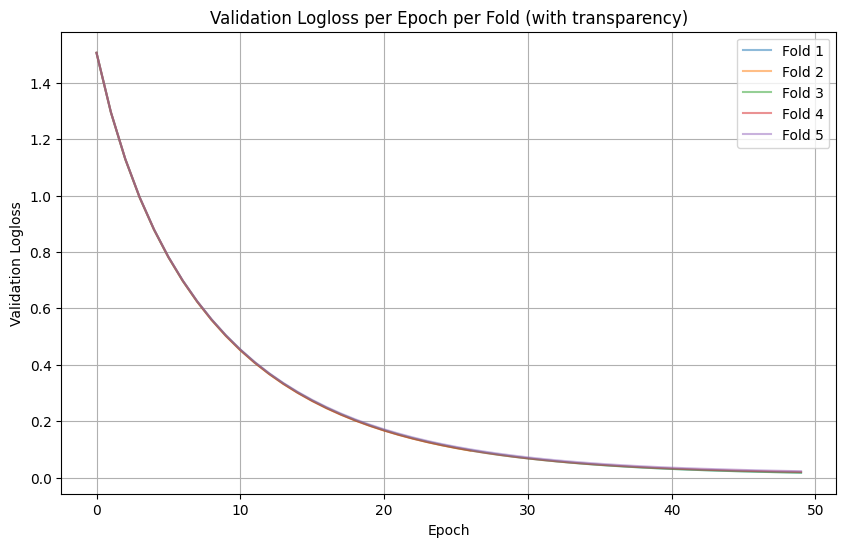

In [ ]:
# Melakukan visualisasi grafik validation logLoss per epoch per Fold dengan visualisasi transparan pada setiap kurvanya agar semua kurva terlihat
functions.plot_curve_transparent(fold_logloss_curve, metric_name="Validation Logloss")

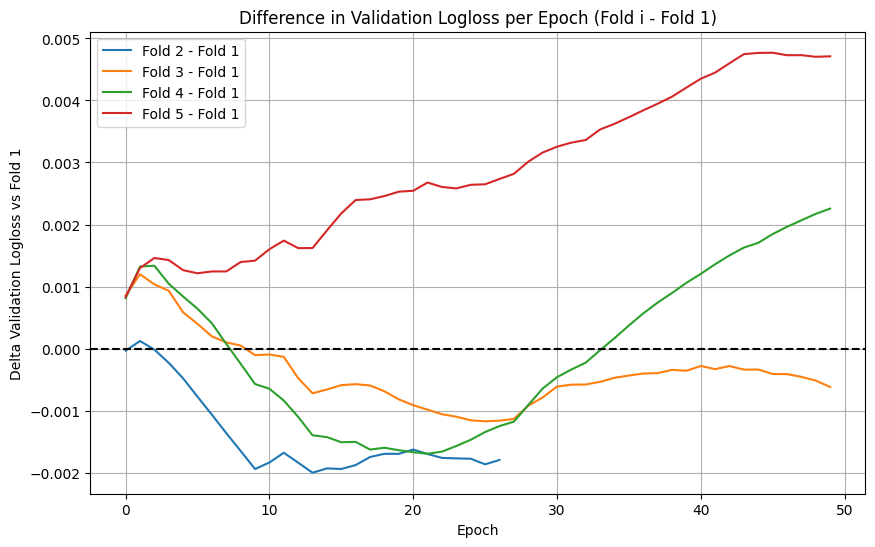

In [ ]:
# Menampilkan visualisasi perbedaan logloss per epoch
functions.plot_curve_deltas(fold_logloss_curve, metric_name="Validation Logloss")

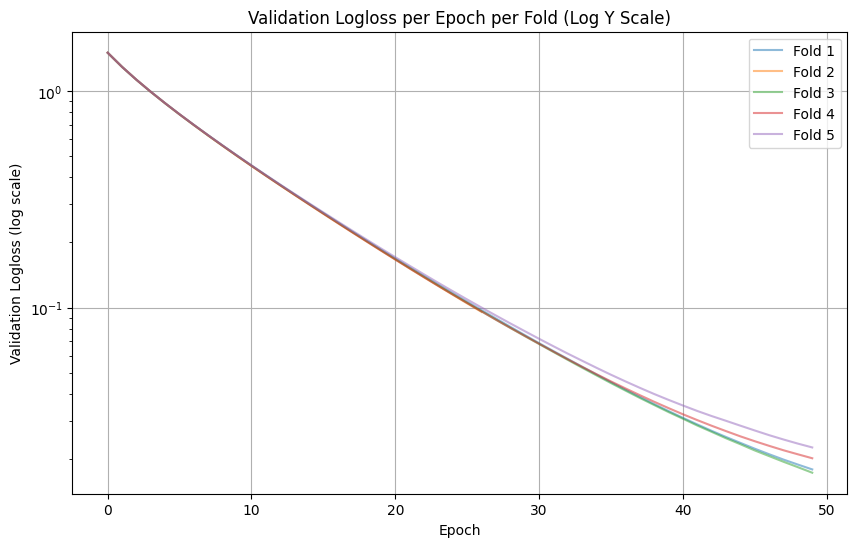

In [ ]:
# Menampilkan visualisasi log gamma-scale agar visualisasi antar kurva lebih terlihat
functions.plot_curve_logscale(fold_logloss_curve, metric_name="Validation Logloss")

## Grafik Accuracy

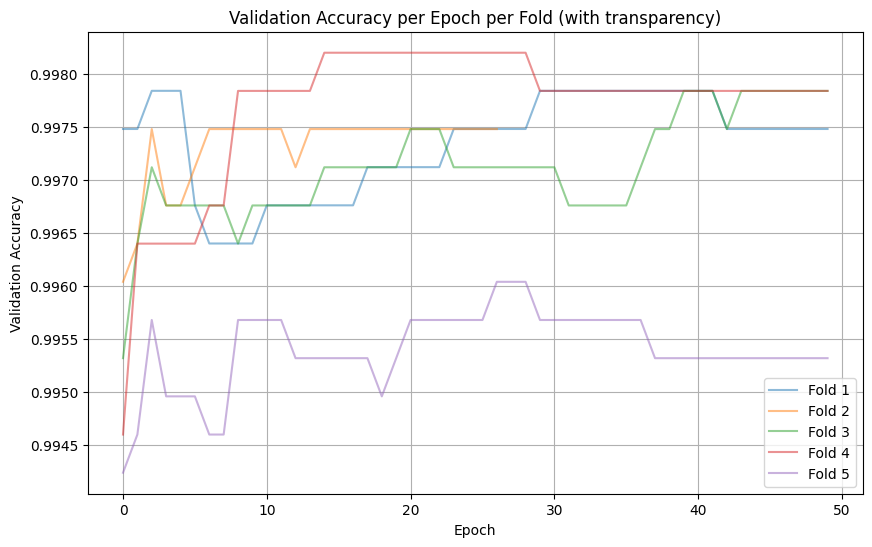

In [ ]:
# Melakukan visualisasi grafik validation accuracy per epoch per Fold dengan visualisasi transparan pada setiap kurvanya agar semua kurva terlihat
functions.plot_curve_transparent(fold_accuracy_curve, metric_name="Validation Accuracy")

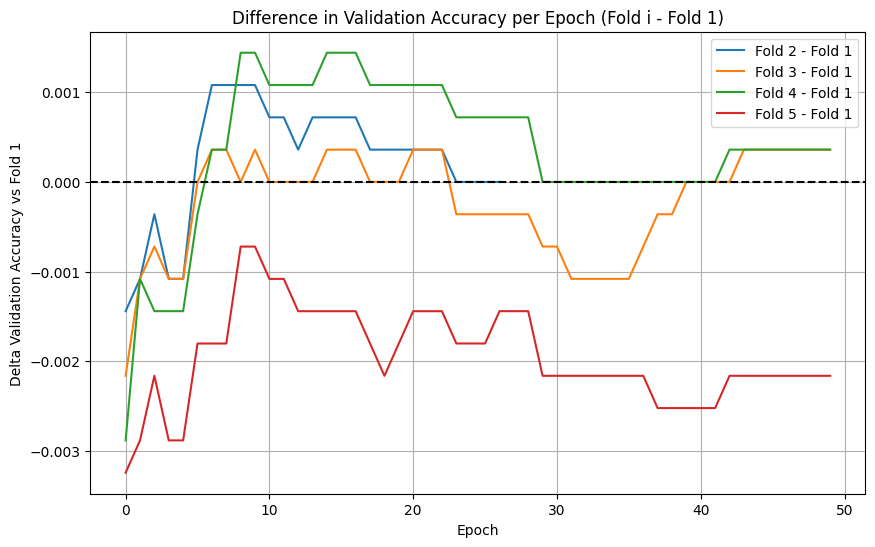

In [ ]:
# Menampilkan visualisasi perbedaan logloss per epoch
functions.plot_curve_deltas(fold_accuracy_curve, metric_name="Validation Accuracy")

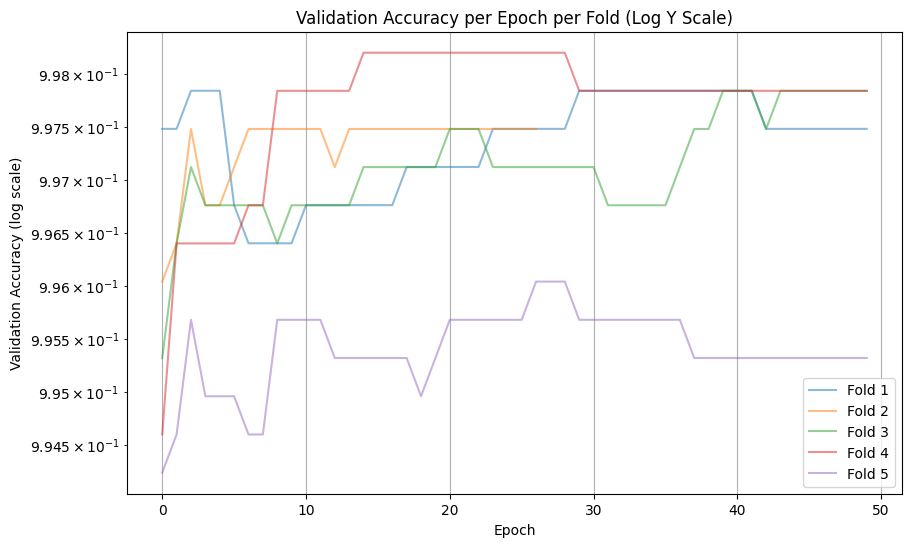

In [ ]:
# Menampilkan visualisasi log gamma-scale agar visualisasi antar kurva lebih terlihat
functions.plot_curve_logscale(fold_accuracy_curve, metric_name="Validation Accuracy")

##  Rangkuman Hasil

In [ ]:
# Rangkuman hasil metrik setiap fold
results_df = pd.DataFrame(fold_results)
print("\n===== K-Fold Summary =====")
print(results_df)


===== K-Fold Summary =====
   fold  accuracy  f1_score  precision   roc_auc  log_loss
0     1  0.997480  0.995742   0.995742  0.999968  0.017887
1     2  0.997479  0.997010   0.998811  0.999970  0.095570
2     3  0.997839  0.998460   0.998606  0.999995  0.017268
3     4  0.997839  0.998598   0.998775  0.999570  0.020143
4     5  0.995319  0.993872   0.990863  0.999972  0.022598


In [ ]:
# Menampilkan rata-rata semua metrik dari semua fold
print("\nMean Metrics:")
print(results_df.drop(columns='fold').mean())


Mean Metrics:
accuracy     0.997191
f1_score     0.996736
precision    0.996559
roc_auc      0.999895
log_loss     0.034693
dtype: float64


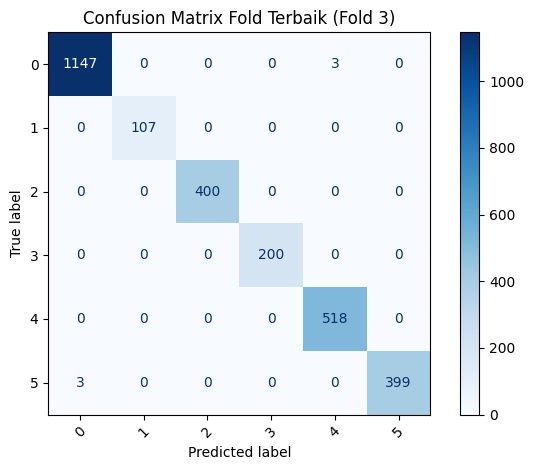

In [ ]:
# Menampilkan visualisasi keakuratan prediksi model
functions.plot_best_confusion_matrix(best_y_true, best_preds, best_fold)